#### after checking the map(html), the ID=02-064 and ID=02-144 are close to the air quality site SiteCode=CD9
#### so import those three datasets and analyze the correlation between the air quality and the congestion

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import os
import geopandas as gpd
from scipy.stats import pearsonr
import pykrige

import statsmodels.api as sm


from scipy.stats import spearmanr, kendalltau

In [29]:


AQ_CD9 = pd.read_csv("Data/AirQuality/PM25/CD1.csv")
CS_02_064 = pd.read_csv("Data/CongestionScoot/MergedCSVs/02-113.csv")
CS_02_144 = pd.read_csv("Data/CongestionScoot/MergedCSVs/02-032.csv")

In [30]:
AQ_CD9.sample(4)

,MeasurementDateGMT,Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)
1363,2018-02-11 19:00,3.8
691,2018-01-14 19:00,24.3
295,2017-12-29 07:00,10.1
878,2018-01-22 14:00,NaN


In [31]:
CS_02_064.sample(4)

,DateTime,Date,Time,SatMean,SatBand,FlowMean
5855,43146.958333,15-Feb-2018,23:00,43.0,0-79%,1202
3024,43117.500000,17-Jan-2018,12:00,63.0,0-79%,1883
4217,43129.927083,29-Jan-2018,22:15,27.0,0-79%,1072
4521,43133.093750,2-Feb-2018,02:15,0.0,0-79%,536


In [32]:
CS_02_144.sample(4)

,DateTime,Date,Time,SatMean,SatBand,FlowMean
1608,43102.750000,2-Jan-2018,18:00,61.75,0-79%,4436
4902,43137.062500,6-Feb-2018,01:30,14.50,0-79%,745
3432,43121.750000,21-Jan-2018,18:00,71.00,0-79%,4920
7330,43162.322917,3-Mar-2018,07:45,45.00,0-79%,2177


***Processing three datasets by merging them together***

In [33]:
# merge the Date and Time columns into a single column
# 将Date和Time列合并为一个字符串列
CS_02_064['DateTimeStr'] = CS_02_064['Date'] + ' ' + CS_02_064['Time']

# convert the merged string to datetime format and create a new column
# 将合并后的字符串转换为datetime格式，并创建一个新列
CS_02_064['MeasurementDateGMT'] = pd.to_datetime(CS_02_064['DateTimeStr'], format='%d-%b-%Y %H:%M')

# drop the middle DateTimeStr column
# 删除中间的DateTimeStr列
CS_02_064.drop(columns=['DateTimeStr'], inplace=True)

# make sure the new column is in datetime format
AQ_CD9['MeasurementDateGMT'] = pd.to_datetime(AQ_CD9['MeasurementDateGMT'])
CS_02_064['MeasurementDateGMT'] = pd.to_datetime(CS_02_064['MeasurementDateGMT'])

# merge the two dataframes
Merged = pd.merge(AQ_CD9, CS_02_064, on='MeasurementDateGMT', how='left')

In [36]:
# adopt some method to interpolate the missing values

# 设置时间列为索引
Corrtest = Merged.set_index('MeasurementDateGMT')

# 对特定列进行样条插值
Corrtest['Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)'] = Corrtest['Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)'].interpolate(method='spline', order=3)
Corrtest['SatMean'] = Corrtest['SatMean'].interpolate(method='spline', order=3)
Corrtest['FlowMean'] = Corrtest['FlowMean'].interpolate(method='spline', order=3)

In [37]:
# check the merged dataframe
Corrtest.head(14)

,Camden - Swiss Cottage: PM2.5 Particulate (ug/m3),DateTime,Date,Time,SatMean,SatBand,FlowMean
MeasurementDateGMT,,,,,,,
2017-12-17 00:00:00,21.2,43086.000000,17-Dec-2017,00:00,37.0,0-79%,1367.0
2017-12-17 01:00:00,19.7,43086.041667,17-Dec-2017,01:00,34.0,0-79%,1267.0
2017-12-17 02:00:00,21.7,43086.083333,17-Dec-2017,02:00,0.0,0-79%,977.0
2017-12-17 03:00:00,16.6,43086.125000,17-Dec-2017,03:00,0.0,0-79%,874.0
2017-12-17 04:00:00,17.3,43086.166667,17-Dec-2017,04:00,0.0,0-79%,498.0
2017-12-17 05:00:00,15.7,43086.208333,17-Dec-2017,05:00,0.0,0-79%,562.0
2017-12-17 06:00:00,16.5,43086.250000,17-Dec-2017,06:00,18.0,0-79%,478.0
2017-12-17 07:00:00,17.7,43086.291667,17-Dec-2017,07:00,18.0,0-79%,505.0
2017-12-17 08:00:00,22.0,43086.333333,17-Dec-2017,08:00,14.0,0-79%,536.0


In [38]:
# 准备数据
X = Corrtest[['SatMean', 'FlowMean']]  # 自变量
y = Corrtest['Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)']  # 因变量

# 添加常数项以拟合截距
X = sm.add_constant(X)

# 拟合多元线性回归模型
model = sm.OLS(y, X).fit()

# 打印模型的摘要
print(model.summary())

                                            OLS Regression Results                                           
Dep. Variable:     Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)   R-squared:                       0.006
Model:                                                           OLS   Adj. R-squared:                  0.005
Method:                                                Least Squares   F-statistic:                     6.813
Date:                                               Wed, 21 Feb 2024   Prob (F-statistic):            0.00112
Time:                                                       01:45:57   Log-Likelihood:                -8056.9
No. Observations:                                               2161   AIC:                         1.612e+04
Df Residuals:                                                   2158   BIC:                         1.614e+04
Df Model:                                                          2                                         
Covariance

In [40]:
corr_coefficient, p_value = pearsonr(Corrtest['Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)'], Corrtest['FlowMean'])
print(f'Pearson_Corr: {corr_coefficient}, p-value: {p_value}')

Pearson_Corr: 0.07886736628314273, p-value: 0.00024267539287821467


In [58]:
Corrtest['Hour'] = Corrtest['Time'].str.split(':').str[0].astype(float)

In [57]:
Corrtest['Hour'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2161 entries, 2017-12-17 00:00:00 to 2018-03-17 00:00:00
Series name: Hour
Non-Null Count  Dtype  
--------------  -----  
2160 non-null   float64
dtypes: float64(1)
memory usage: 33.8 KB


C:\Users\SBH\AppData\Local\Temp\ipykernel_31456\170009022.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap)


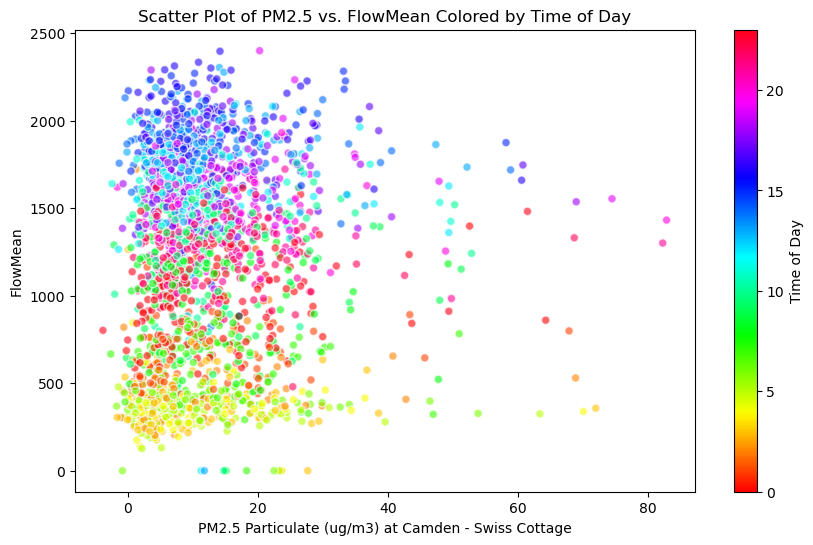

In [63]:
norm = colors.Normalize(vmin=Corrtest['Hour'].min(), vmax=Corrtest['Hour'].max())

# 接下来，创建一个颜色映射对象
cmap = cm.ScalarMappable(norm=norm, cmap='hsv')

plt.figure(figsize=(10, 6))
plt.scatter(x='Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)',
            y='FlowMean',
            c=cmap.to_rgba(Corrtest['Hour']),  # 使用颜色映射对象为数据点着色
            data=Corrtest,
            alpha=0.6,  
            edgecolors='w')  

# 添加色带
cbar = plt.colorbar(cmap)
cbar.set_label('Time of Day')

plt.xlabel('PM2.5 Particulate (ug/m3) at Camden - Swiss Cottage')
plt.ylabel('FlowMean')
plt.title('Scatter Plot of PM2.5 vs. FlowMean Colored by Time of Day')
plt.show()

In [44]:

# calculate the Spearman correlation
spearman_corr, spearman_p_value = spearmanr(Corrtest['Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)'], 
                                             Corrtest['FlowMean'])
print(f'Spearman Corr: {spearman_corr}, p-value: {spearman_p_value}')

# calculate the Kendall correlation
kendall_corr, kendall_p_value = kendalltau(Corrtest['Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)'], 
                                           Corrtest['FlowMean'])
print(f'Kendall Tau: {kendall_corr}, p-value: {kendall_p_value}')

Spearman Corr: 0.13070839219926644, p-value: 1.0683508112132132e-09
Kendall Tau: 0.08648932935406593, p-value: 1.8243122594755007e-09
